In [1]:
# imports 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score ,precision_score ,recall_score ,f1_score
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
import tensorflow as tf 
from tensorflow import keras

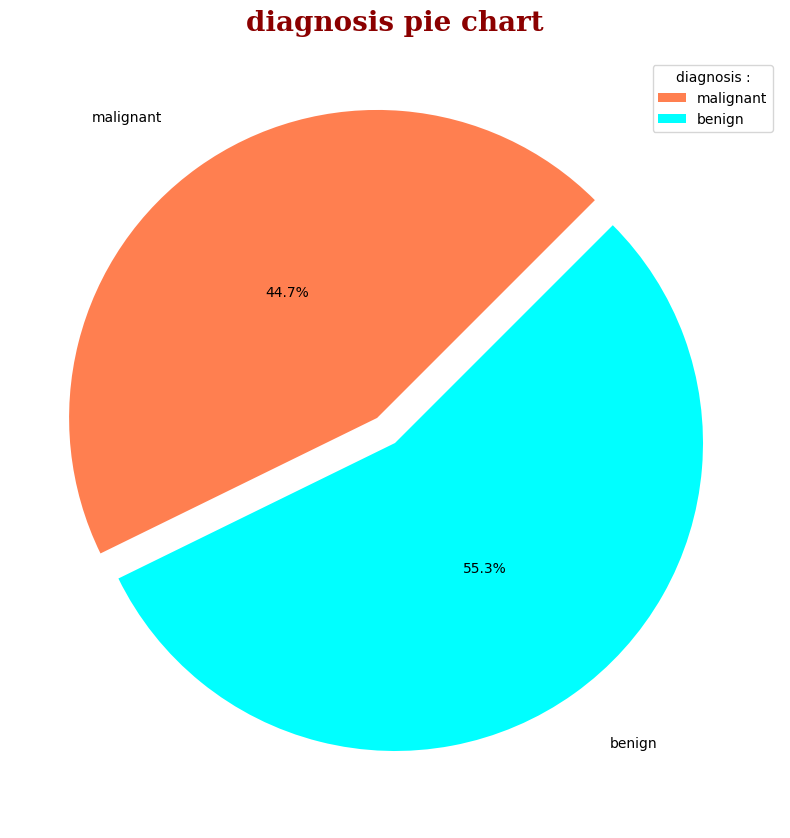

In [6]:
# preprocessing
SAMPLE =2000
radius =(np.random.rand(SAMPLE) *100).reshape(-1,1)
area =(np.random.rand(SAMPLE) *100).reshape(-1,1)
premeter =(np.random.normal(loc =500.0 ,scale =100.0 ,size =SAMPLE)).reshape(-1,1)
texture =(np.random.normal(loc =5 ,scale =1.5 ,size =SAMPLE)).reshape(-1,1)
diagnosis =[]
true_count =0
false_count =0
diagnosis_count =[]
for i in range(SAMPLE) : 
    if radius[i ,0] >=30.0 and area[i ,0] >=30.0 and premeter[i ,0] >=300.0 and texture[i ,0] >=3.0 : 
        diagnosis.append(1)
        true_count +=1
    else :
        diagnosis.append(0)
        false_count +=1
diagnosis_count.append(true_count)
diagnosis_count.append(false_count)
diagnosis =np.asarray(diagnosis ,dtype =np.int32).reshape(-1,1)
data =np.concatenate((radius ,area ,premeter ,texture) ,axis =1)
data_norm =minmax_scale(data ,feature_range=(0,1)).astype(np.float32)
xtr ,xte ,ytr ,yte =train_test_split(data ,diagnosis ,train_size=0.8)
colors =['coral' ,'cyan'] 
labels =['malignant' ,'benign']
explods =[0.1 ,0.0]
font_title ={'family': 'serif',
        'color':  'darkred',
        'weight': 'bold',
        'size': 20,
        }
fig =plt.figure(num =1 ,dpi =100 ,figsize =(10,10))
ax1 =fig.add_subplot(1,1,1)
ax1.pie(diagnosis_count ,
        colors =colors ,
        labels =labels ,
        explode =explods ,
        startangle =45 ,
        autopct ='%1.1f%%' ,
        pctdistance =0.5 ,
        labeldistance =1.2)
plt.title(label ='diagnosis pie chart' ,pad =20 ,fontdict =font_title)
plt.legend(title ='diagnosis :')
plt.show()

In [3]:
# model creation 
def create_model(a_function ,h_unit ,l_rate) : 
  model =keras.Sequential()
  model.add(keras.layers.Dense(units =h_unit ,input_dim =4))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation(a_function))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(units =h_unit))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation(a_function))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(units =h_unit))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation(a_function))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(units =h_unit))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation(a_function))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(units =h_unit))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation(a_function))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(units =1))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation('sigmoid'))
  model.compile(optimizer =keras.optimizers.Adam(learning_rate =l_rate) ,
                loss ='binary_crossentropy' ,
                metrics =['binary_accuracy'])
  return model

In [4]:
# random search cross validation 
cls = KerasClassifier(create_model ,
                    optimizer =keras.optimizers.Adam(learning_rate=0.0001) ,
                    loss =keras.losses.BinaryCrossentropy ,
                    metrics =[keras.metrics.BinaryAccuracy] ,
                    batch_size =32 ,
                    validation_batch_size= 16,
                    epochs =1 ,
                    verbose =2
)
params ={ 
    'model__a_function' : ['relu' ,'tanh'] ,
    'model__h_unit' : [256 ,512] ,
    'model__l_rate' : [0.0003 ,0.0005]
}
rs =RandomizedSearchCV(estimator =cls ,param_distributions =params ,cv =4 ,n_iter =5)
rs_result =rs.fit(xtr ,ytr)

c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 7s - 183ms/step - binary_accuracy: 0.7825 - loss: 0.5160
13/13 - 1s - 39ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 6s - 162ms/step - binary_accuracy: 0.7675 - loss: 0.5389
13/13 - 1s - 39ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 7s - 184ms/step - binary_accuracy: 0.7600 - loss: 0.5320
13/13 - 1s - 42ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 9s - 248ms/step - binary_accuracy: 0.7642 - loss: 0.5234
13/13 - 1s - 39ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 7s - 185ms/step - binary_accuracy: 0.7625 - loss: 0.5151
13/13 - 1s - 40ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 13s - 346ms/step - binary_accuracy: 0.7575 - loss: 0.5188
13/13 - 1s - 43ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 7s - 176ms/step - binary_accuracy: 0.7350 - loss: 0.5292
13/13 - 1s - 69ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 8s - 200ms/step - binary_accuracy: 0.7492 - loss: 0.5250
13/13 - 1s - 80ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 6s - 171ms/step - binary_accuracy: 0.6508 - loss: 0.6259
13/13 - 1s - 41ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 9s - 247ms/step - binary_accuracy: 0.6725 - loss: 0.6128
13/13 - 1s - 43ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 7s - 176ms/step - binary_accuracy: 0.6517 - loss: 0.6392
13/13 - 0s - 37ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 9s - 244ms/step - binary_accuracy: 0.6325 - loss: 0.6589
13/13 - 1s - 51ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 7s - 172ms/step - binary_accuracy: 0.7317 - loss: 0.5573
13/13 - 0s - 33ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 6s - 156ms/step - binary_accuracy: 0.7375 - loss: 0.5697
13/13 - 1s - 39ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 6s - 163ms/step - binary_accuracy: 0.7550 - loss: 0.5478
13/13 - 1s - 43ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 7s - 185ms/step - binary_accuracy: 0.7317 - loss: 0.5533
13/13 - 1s - 42ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 7s - 178ms/step - binary_accuracy: 0.7525 - loss: 0.5335
13/13 - 0s - 36ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 7s - 176ms/step - binary_accuracy: 0.7233 - loss: 0.5489
13/13 - 1s - 41ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 8s - 213ms/step - binary_accuracy: 0.7333 - loss: 0.5434
13/13 - 0s - 37ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 - 6s - 165ms/step - binary_accuracy: 0.7142 - loss: 0.5539
13/13 - 0s - 35ms/step


c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 - 7s - 141ms/step - binary_accuracy: 0.6850 - loss: 0.6134


In [7]:
# retrain
best_params =rs_result.best_params_
model =create_model(best_params['model__a_function'] ,best_params['model__h_unit'] ,best_params['model__l_rate'])
model_path ='model.keras'
model.save(model_path ,overwrite =True ,zipped=None)
epochs =100 
batch_size =32
hist =model.fit(xtr ,ytr ,batch_size =batch_size ,epochs =epochs ,validation_data =(xte ,yte) ,verbose =2)

c:\Users\fujitsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
50/50 - 6s - 126ms/step - binary_accuracy: 0.6488 - loss: 0.6414 - val_binary_accuracy: 0.6750 - val_loss: 0.6160
Epoch 2/100
50/50 - 0s - 8ms/step - binary_accuracy: 0.7844 - loss: 0.4989 - val_binary_accuracy: 0.4500 - val_loss: 0.7187
Epoch 3/100
50/50 - 0s - 8ms/step - binary_accuracy: 0.8313 - loss: 0.4704 - val_binary_accuracy: 0.6350 - val_loss: 0.6073
Epoch 4/100
50/50 - 0s - 8ms/step - binary_accuracy: 0.8300 - loss: 0.4624 - val_binary_accuracy: 0.7775 - val_loss: 0.4928
Epoch 5/100
50/50 - 0s - 8ms/step - binary_accuracy: 0.8537 - loss: 0.4447 - val_binary_accuracy: 0.8425 - val_loss: 0.4288
Epoch 6/100
50/50 - 0s - 8ms/step - binary_accuracy: 0.8444 - loss: 0.4483 - val_binary_accuracy: 0.8750 - val_loss: 0.4062
Epoch 7/100
50/50 - 0s - 8ms/step - binary_accuracy: 0.8419 - loss: 0.4446 - val_binary_accuracy: 0.8825 - val_loss: 0.3990
Epoch 8/100
50/50 - 1s - 14ms/step - binary_accuracy: 0.8569 - loss: 0.4342 - val_binary_accuracy: 0.9025 - val_loss: 0.3832
Epoch

In [8]:
# model evaluation 
Y =model.predict(xte) 
Yte =(Y > 0.5).astype(np.int32)
eva =[]
acc =accuracy_score(y_true =yte ,y_pred =Yte)
pre =precision_score(y_true =yte ,y_pred =Yte)
re =recall_score(y_true =yte ,y_pred =Yte)
f1 =f1_score(y_true =yte ,y_pred =Yte)
eva.append(acc)
eva.append(pre)
eva.append(re)
eva.append(f1)
eva

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


[0.885, 0.953125, 0.7530864197530864, 0.8413793103448276]

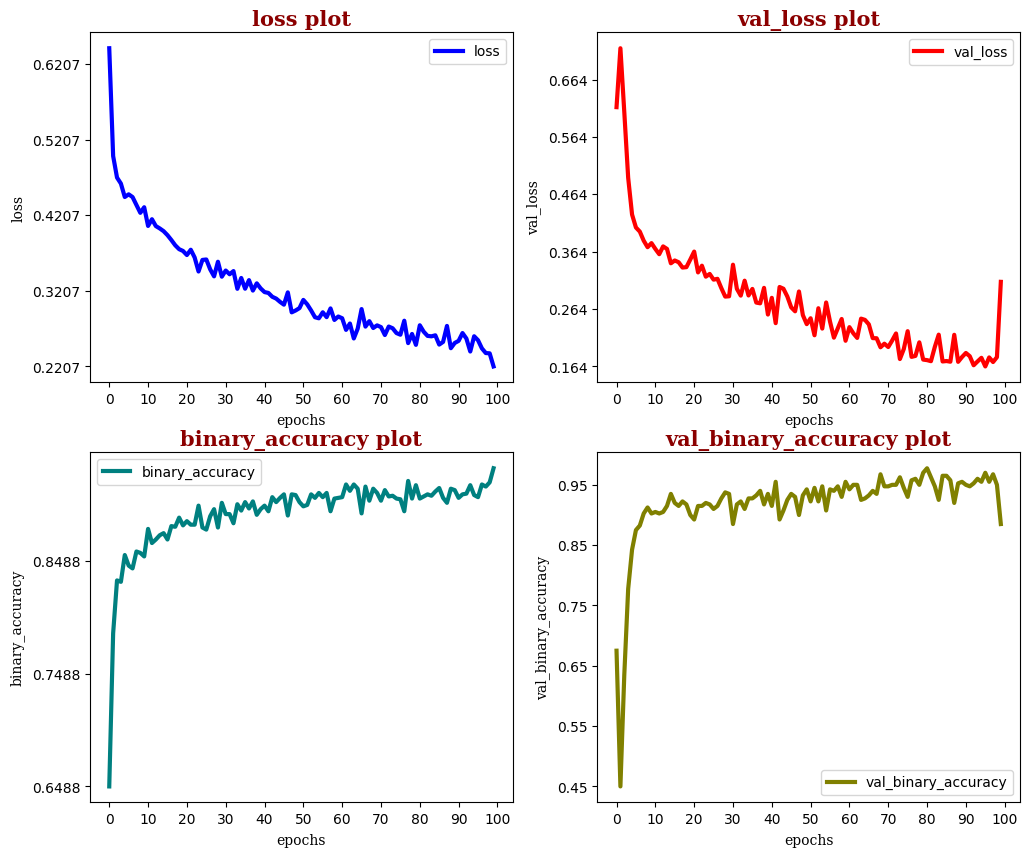

In [17]:
# evaluation plot
def font_config(family ,color ,weight ,size) : 
    font ={'family': family ,
        'color':  color ,
        'weight': weight ,
        'size': size 
        }
    return font
def plot_detail(plot ,scale) : 
    font_label =font_config('serif' ,'black' ,'normal' ,10)
    font_title =font_config('serif' ,'darkred' ,'bold' ,15)
    plt.xticks(ticks =np.arange(0 ,epochs+1 ,10))
    plt.yticks(ticks =np.arange(np.min(hist.history[plot]) ,np.max(hist.history[plot]) ,scale))
    plt.xlabel(xlabel ='epochs' ,labelpad =5 ,fontdict =font_label)
    plt.ylabel(ylabel =plot ,labelpad =5 ,fontdict =font_label)
    plt.title(label =f'{plot} plot' ,pad=5 ,fontdict =font_title)
    plt.legend()
fig =plt.figure(num =2 ,figsize =(12,10) ,dpi =100) 
ax1 =fig.add_subplot(2,2,1)
ax1.plot(hist.history['loss'] ,color ='blue' ,lw =3 ,ls ='-' ,label ='loss')
plot_detail('loss' ,0.1)
ax2 =fig.add_subplot(2,2,2)
ax2.plot(hist.history['val_loss'] ,color ='red' ,lw =3 ,ls ='-' ,label ='val_loss')
plot_detail('val_loss' ,0.1)
ax3 =fig.add_subplot(2,2,3)
ax3.plot(hist.history['binary_accuracy'] ,color ='teal' ,lw =3 ,ls ='-' ,label ='binary_accuracy')
plot_detail('binary_accuracy' ,0.1)
ax4 =fig.add_subplot(2,2,4)
plt.plot(hist.history['val_binary_accuracy'] ,color ='olive' ,lw =3 ,ls ='-' ,label ='val_binary_accuracy')
plot_detail('val_binary_accuracy' ,0.1)
plt.show()